## BDEW method

$$
{\vartheta}_{d}=\frac{{\vartheta}_{d}+0.5\,{\vartheta}_{d-1}^{amb}+0.25\,{\vartheta}_{d-2}^{amb}+0.125\,{\vartheta}_{d-3}^{amb}}{1+0.5+0.25+0.125}
$$

$$
{h}({\vartheta}_{d})=\frac{A}{1+{\left(\frac{B}{{\vartheta}_{d}-{\vartheta}_{0}}\right)}^{C}}+D+max\left\{\begin{array}{c}{m}_{h}\cdot {\vartheta}_{d}+{b}_{h}\\ {m}_{w}\cdot {\vartheta}_{d}+{b}_{w}\end{array}\right\},
$$

In [2]:
import pandas as pd
temps = pd.read_csv("data/canada/CA_provinces_temperatures.csv", index_col=0, parse_dates=True)
ontario_temp = temps["Ontario"]

# BDEW method for SLP: Leitfaden_20160630_Abwicklung-Standardlastprofile-Gas.pdf
ot_dm = ontario_temp.groupby(ontario_temp.index.dayofyear).mean()
T_ref = (ot_dm + 0.5 * ot_dm.shift(1) + 0.25 * ot_dm.shift(2) + 0.125 * ot_dm.shift(3) )/(1+0.5+0.25+0.125)


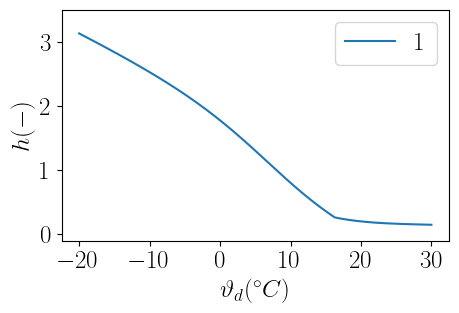

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

plt.rcParams["text.usetex"] = True

# coefficients for MFH. DE_HMF34, 2D4
A =   1.0443538
B = -35.0333754
C =   6.2240634
D =   0.0502917
T_0 = 40
m_H = -0.0535830
b_H = 0.9995901
m_W = -0.002176
b_W = 0.16332

@np.vectorize
def f_dl(T_ref):
    first_term = A/(1+(B/(T_ref-T_0))**C) +D
    second_term = max((m_H*T_ref + b_H), (m_W*T_ref + b_W))
    return first_term + second_term

outdoor_t = np.linspace(-20,30,1000)

fdl = f_dl(outdoor_t)
fig, ax = plt.subplots(figsize=(5,3))
ax = pd.DataFrame(zip(outdoor_t, fdl)).set_index(0).plot(ax=ax)
ax.set_ylim((-0.1,3.5))
ax.set_ylabel("$h (-)$")
ax.set_xticks(np.arange(-20,31,10))
ax.set_xlabel(r"$\vartheta_{d} (^{\circ} C$)")
ax.figure.savefig("SLP_h.svg")

In [4]:
ot_daily_ref = pd.DataFrame(zip(T_ref.index, f_dl(T_ref))).set_index(0).rename({1:"daily"}, axis=1)
ot_daily_ref.index = pd.date_range(start=ontario_temp.index[0], end=ontario_temp.index[-1], freq="d")
ot_daily_ref



c:\Users\dhuck\miniconda3\envs\cando\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in f_dl (vectorized)
  outputs = ufunc(*inputs)


,daily
2013-01-01,NaN
2013-01-02,NaN
2013-01-03,NaN
2013-01-04,2.071980
2013-01-05,1.936875
...,...
2013-12-27,2.202482
2013-12-28,1.905275
2013-12-29,1.700662
2013-12-30,2.102818


In [5]:
from components.probability import beta_with_mode_at

# px.histogram(beta_with_mode_at(0.8, 1000, interval=(-1,0)))

In [6]:
import plotly.express as px


def shift_ts(input_ts, shift_len):
    if shift_len == 0:
        return input_ts
    shifted = input_ts.shift(shift_len)
    if shift_len < 0:
        shifted.iloc[shift_len:] = ontario_temp.iloc[:-shift_len]
    else:
        shifted.iloc[:shift_len] = input_ts.iloc[-shift_len:]
    return shifted


def generate_agg_heat_demand(
    temp_ts,
    set_temp=20,
    n_random_samples=1000,
    t_shift=72,
    norm=True,
    inverse_scaling=False,
):
    dT = set_temp - temp_ts
    dT[dT < 0] = 0

    # r = beta_with_mode_at(0.8, n_random_samples, interval=(-1,0)) * t_shift
    r = np.random.normal(0,t_shift/2,n_random_samples)
    # r = (np.random.random(n_random_samples) - 0.5) * t_shift
    r = r.astype(int)

    r_shifted_ts = []
    if inverse_scaling:
        inverses = abs(1 / 2**(r/24))
        inverses[inverses == np.inf] = 1

    for i, R in enumerate(r):
        shifted = shift_ts(dT, R)
        if inverse_scaling:
            r_shifted_ts.append(shifted * inverses[i])
        else:
            r_shifted_ts.append(shifted)

    if inverse_scaling:
        merged_ts = pd.concat(r_shifted_ts, axis=1).sum(axis=1) / sum(inverses)
    else:
        merged_ts = pd.concat(r_shifted_ts, axis=1).sum(axis=1)

    merged_ts.name = f"ABM n={n_random_samples}"
    if norm:
        r_heat_agg_norm = merged_ts.div(merged_ts.max())
        return r_heat_agg_norm
    else:
        return merged_ts


roll_dt = 24
ot_hm = (
    ontario_temp.rolling(roll_dt, center=True, min_periods=1).mean()
    + 0.5  * shift_ts(ontario_temp,   roll_dt).rolling(roll_dt, center=True, min_periods=1).mean()
    + 0.25 * shift_ts(ontario_temp, 2*roll_dt).rolling(roll_dt, center=True, min_periods=1).mean()
    + 0.125* shift_ts(ontario_temp, 3*roll_dt).rolling(roll_dt, center=True, min_periods=1).mean()
) / (1 + 0.5 + 0.25 + 0.125)

ot_h_ref = (
    pd.DataFrame(zip(ot_hm.index, f_dl(ot_hm)))
    .set_index(0)
    .rename({1: "hourly"}, axis=1)
)


In [28]:
demand_n100 = generate_agg_heat_demand(ontario_temp,t_shift=3*roll_dt, n_random_samples=100)
demand_n500 = generate_agg_heat_demand(ontario_temp,t_shift=3*roll_dt, n_random_samples=500)
demand_n5000 = generate_agg_heat_demand(ontario_temp,t_shift=3*roll_dt, n_random_samples=5000)
plot_frame = pd.concat(
    [
        # ot_h_ref["hourly"].div(ot_h_ref["hourly"].max()),
        # generate_agg_heat_demand(ontario_temp,t_shift=3*roll_dt, n_random_samples=200),
        demand_n100,
        demand_n500,
        demand_n5000,
    ], axis=1
)

(time
 2013-01-01 00:00:00    0.828436
 2013-01-01 01:00:00    0.829218
 2013-01-01 02:00:00    0.822503
 2013-01-01 03:00:00    0.819123
 2013-01-01 04:00:00    0.811959
                          ...   
 2013-12-31 19:00:00    0.498197
 2013-12-31 20:00:00    0.480755
 2013-12-31 21:00:00    0.461255
 2013-12-31 22:00:00    0.452388
 2013-12-31 23:00:00    0.443803
 Name: ABM n=100, Length: 8760, dtype: float64,)

In [40]:
ot_daily_ref["daily_norm"] = ot_daily_ref["daily"]/ot_daily_ref["daily"].max()
demand_n500_daily_mean = demand_n500.groupby(pd.Grouper(freq="D")).mean()
worst_week = (ot_daily_ref["daily_norm"][:-3]-demand_n500_daily_mean[:-3]).groupby(pd.Grouper(freq="W")).sum().argmax()
best_week = (ot_daily_ref["daily_norm"][:-3]-demand_n500_daily_mean[:-3]).groupby(pd.Grouper(freq="W")).sum().argmin()
best_week, worst_week

(18, 34)

In [51]:
plot_frame["week"] = plot_frame.index.dayofyear//7
display_idx = (plot_frame["week"]==best_week)|(plot_frame["week"]==worst_week)
plot_frame

,ABM n=100,ABM n=500,ABM n=5000,week
time,,,,
2013-01-01 00:00:00,0.813253,0.831587,0.829898,0
2013-01-01 01:00:00,0.819187,0.829739,0.829993,0
2013-01-01 02:00:00,0.820236,0.829876,0.829396,0
2013-01-01 03:00:00,0.820373,0.829553,0.829837,0
2013-01-01 04:00:00,0.824031,0.825131,0.830389,0
...,...,...,...,...
2013-12-31 19:00:00,0.428759,0.438396,0.421173,52
2013-12-31 20:00:00,0.420777,0.429310,0.410487,52
2013-12-31 21:00:00,0.421492,0.420988,0.400338,52


In [58]:

plot_frame_l = plot_frame.loc[(plot_frame["week"]==best_week)|(plot_frame["week"]==worst_week), :].melt(id_vars="week", ignore_index=False)
plot_frame_l["week"] = plot_frame_l["week"].replace({best_week:"best week", worst_week:"worst week"})

In [73]:
import plotly.graph_objects as go
from figures import sciencify_plotly_fig

if "week" in plot_frame.columns:
    plot_frame.drop("week", axis=1, inplace=True)
fig = px.line(plot_frame)
fig.add_trace(go.Scatter(x=ot_daily_ref.index, y=ot_daily_ref["daily"]/ot_daily_ref["daily"].max(), name="SLP"), )
# fig = px.line(plot_frame_l.reset_index(), x="time",color="variable", y="value", facet_col="week")
# fig.update_xaxes(matches=None)
# fig.add_trace(go.Scatter(x=ot_daily_ref.index, y=ot_daily_ref["daily"]/ot_daily_ref["daily"].max(), name="BDEW"), col=1, row=1)
# fig.add_trace(go.Scatter(x=ot_daily_ref.index, y=ot_daily_ref["daily"]/ot_daily_ref["daily"].max(), name="BDEW"), col=2, row=1)

fig = sciencify_plotly_fig(fig)
fig.update_layout(yaxis_title="Normalized aggregated demand (-)", width=800)


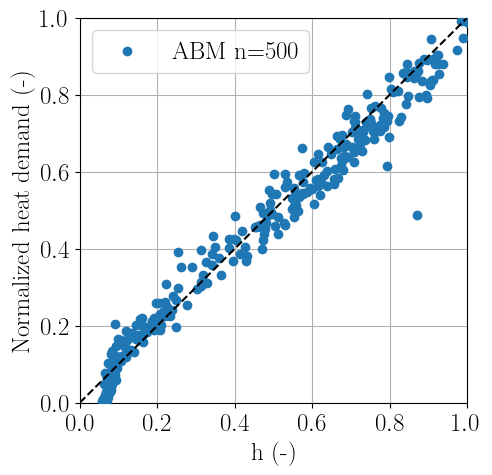

In [80]:
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] ="True"
plt.rcParams["font.family"] ="cm"
plt.rcParams["font.size"] =18
# comp_frame = plot_frame.loc[ot_daily_ref.index,]
comp_frame = plot_frame.groupby(pd.Grouper(freq="D")).mean()
comp_frame["BDEW"] = ot_daily_ref["daily"]/ot_daily_ref["daily"].max()
# px.scatter(x=comp_frame["BDEW"],y=comp_frame["ABM_agg_n=5000"], width=400, height=400)
fig, ax = plt.subplots(figsize=(5,5))
ax.grid(zorder=-1)
ax.scatter(comp_frame["BDEW"], comp_frame["ABM n=500"], label="ABM n=500", zorder=4)
# ax.scatter(comp_frame["BDEW"], comp_frame["ABM n=100"], label="ABM n=100", zorder=4)
# ax.scatter(comp_frame["BDEW"], comp_frame["ABM n=5000"], label="ABM n=5000", zorder=4)
# ax.scatter(comp_frame["BDEW"], comp_frame["ABM_agg_n=5000"], label="ABM_agg_n=5000")
ax.set_xlabel(r"h (-)")
ax.set_ylabel("Normalized heat demand (-)")
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.legend()
ax.plot([0,1],[0,1], "--", color="black", zorder=4)
ax.figure.savefig("aggregated_demand_vs_SLP.svg")

In [96]:
comp_frame.max()/comp_frame.mean()

ABM n=100     2.536382
ABM n=500     2.543673
ABM n=5000    2.537857
BDEW          2.487225
dtype: float64

In [98]:
comp_frame["ABM n=500"]

time
2013-01-01    0.828411
2013-01-02    0.800710
2013-01-03    0.769450
2013-01-04    0.723613
2013-01-05    0.688690
                ...   
2013-12-27    0.742110
2013-12-28    0.700466
2013-12-29    0.664533
2013-12-30    0.614872
2013-12-31    0.488041
Freq: D, Name: ABM n=500, Length: 365, dtype: float64

time
2013-01-01         NaN
2013-01-02         NaN
2013-01-03         NaN
2013-01-04    0.780103
2013-01-05    0.729236
                ...   
2013-12-27    0.829237
2013-12-28    0.717338
2013-12-29    0.640301
2013-12-30    0.791713
2013-12-31    0.870754
Freq: D, Name: BDEW, Length: 365, dtype: float64

In [100]:
from scipy.stats import pearsonr

pearsonr(comp_frame["BDEW"][4:], comp_frame["ABM n=500"][4:])

PearsonRResult(statistic=0.9880381178087396, pvalue=1.45056210620207e-293)

: 

Text(0.5, 0, 'peak to mean ratio (-)')

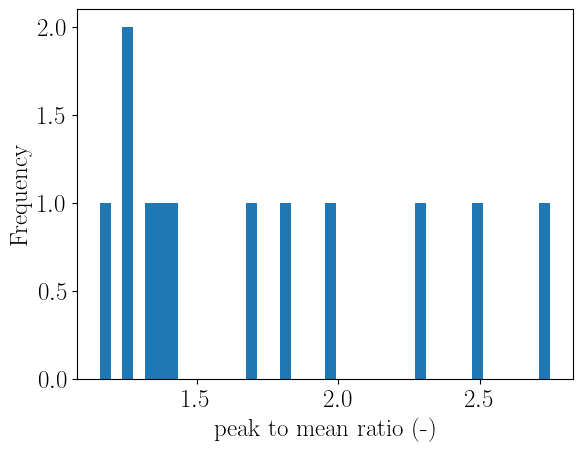

In [83]:
p2m_ratio = plot_frame.groupby(plot_frame.index.month).agg(["max","mean"])
ax = (p2m_ratio["ABM n=500"]["max"]/p2m_ratio["ABM n=500"]["mean"]).plot(kind="hist", bins=40)
ax.set_xlabel("peak to mean ratio (-)")

In [92]:
p2m_ratio.columns = p2m_ratio.columns.swaplevel()

p2m_ratio
# p2m_ratio.loc[:,"max",:]/p2m_ratio.loc[:,"mean",:]

,max,mean,max,mean,max,mean
,ABM n=100,ABM n=100,ABM n=500,ABM n=500,ABM n=5000,ABM n=5000
time,,,,,,
1,1.000000,0.712540,1.000000,0.715649,1.000000,0.719674
2,0.922073,0.799830,0.927235,0.803141,0.919804,0.807348
3,0.847231,0.667874,0.852502,0.670901,0.849854,0.674791
4,0.661241,0.482907,0.663840,0.485477,0.655573,0.488836
5,0.405609,0.234285,0.393900,0.235358,0.395744,0.237081
6,0.213208,0.094203,0.216892,0.094630,0.211444,0.095211
7,0.063198,0.023962,0.059964,0.024068,0.055877,0.024179
8,0.098041,0.033147,0.091461,0.033255,0.087940,0.033559


<Axes: xlabel='time'>

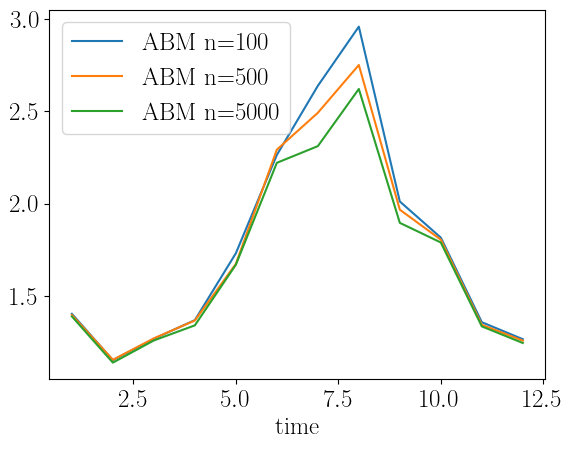

In [95]:
(p2m_ratio.loc[:,"max"]/p2m_ratio.loc[:,"mean"]).plot()

# exporting time series shapes

In [ ]:
agg_heat_demands = [generate_agg_heat_demand(temps[col], n_random_samples=5000) for col in temps.columns]

In [ ]:
canada_agg_demand_shapes = pd.concat(agg_heat_demands, axis=1)
canada_agg_demand_shapes.columns = temps.columns
canada_agg_demand_shapes

,Quebec,Newfoundland and Labrador,British Columbia,New Brunswick,Nova Scotia,Saskatchewan,Alberta,Prince Edward Island,Manitoba,Ontario,Canada
time,,,,,,,,,,,
2013-01-01 00:00:00,0.806165,0.830948,0.708917,0.815579,0.774184,0.815222,0.629706,0.798086,0.907785,0.829604,0.868369
2013-01-01 01:00:00,0.807484,0.829622,0.709064,0.817489,0.776654,0.811392,0.629565,0.799268,0.904255,0.830097,0.868017
2013-01-01 02:00:00,0.808304,0.828667,0.709234,0.818919,0.779254,0.807651,0.628991,0.800859,0.900677,0.830861,0.867635
2013-01-01 03:00:00,0.809076,0.828008,0.709364,0.820834,0.781669,0.804335,0.628332,0.802102,0.897228,0.831465,0.867466
2013-01-01 04:00:00,0.810185,0.827338,0.710047,0.822895,0.783845,0.801187,0.627211,0.803459,0.893394,0.831166,0.866993
...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,0.414433,0.414063,0.265093,0.387863,0.342550,0.505386,0.315086,0.367558,0.555283,0.399872,0.448097
2013-12-31 20:00:00,0.406822,0.402146,0.255998,0.379865,0.337462,0.493968,0.306436,0.360764,0.541334,0.388755,0.435982
2013-12-31 21:00:00,0.396929,0.390477,0.244898,0.372210,0.327593,0.480561,0.298010,0.352028,0.528245,0.379803,0.422528


In [ ]:
canada_agg_demand_shapes.to_pickle("data/canada/timeseries/canada_agg_demand_shapes.pkl")